In [1]:
%matplotlib inline

import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import torch
import os
import sys
import glob
import pickle
import copy
import random
import time
import traceback
import shutil

from multiprocessing import Process, Manager

# Config

In [2]:
PROJECT_ROOT = '/workspace/GREAT_ASV_system/'
sys.path.append(PROJECT_ROOT)

In [3]:
# OPT_INDEX = '/workspace/DATASET/server9/STD_SRE_EGS'
# if not os.path.exists(OPT_INDEX):
#     os.mkdir(OPT_INDEX)
    
OPT_INDEX = '/workspace/DATASET/server9_ssd/STD_SRE_EGS'
if not os.path.exists(OPT_INDEX):
    os.mkdir(OPT_INDEX)

In [4]:
SRE_TRAIN_DIR = '/workspace/DATASET/server9/SRE_SWBD_WAV'
AUG_INFO_DIR = '/workspace/DATASET/server9/STD_musan&rir_info'

In [5]:
INFO_DIR = os.path.join(OPT_INDEX, 'STD_INFO')
if not os.path.exists(INFO_DIR):
    os.mkdir(INFO_DIR)

spk2id = os.path.join(INFO_DIR, 'spk2id')
spk2utt_dict = os.path.join(INFO_DIR, 'spk2utt_dict')
spk2utt_train_dict = os.path.join(INFO_DIR, 'spk2utt_train_dict')
spk2utt_val_dict = os.path.join(INFO_DIR, 'spk2utt_val_dict')
spk2utt_train_len = os.path.join(INFO_DIR, 'spk2utt_train_len')
spk2utt_val_len = os.path.join(INFO_DIR, 'spk2utt_val_len')

In [6]:
val_utt_num = 200

# Make spk2utt dict

In [8]:
spk2utt = {}
spk2utt_train = {}
spk2utt_val = {}

with open(spk2id, 'w') as f:
    pass

label_dir = glob.glob(SRE_TRAIN_DIR+'/*/*')
label = [i.split('/')[-1] for i in label_dir]

for count, i in enumerate(label):
    with open(spk2id, 'a') as f:
        f.write(str(count)+','+i+'\n')
    spk2utt[count] = glob.glob(os.path.join(SRE_TRAIN_DIR, 'SRE16_TRAIN', i)+'/*.wav')

In [10]:
len(spk2utt)

7001

In [11]:
count = 0
count_list = []
for i in spk2utt:
    count += len(spk2utt[i])
    count_list.append(len(spk2utt[i]))
print(count)

91261


In [12]:
with open(spk2utt_dict, 'wb') as handle:
    pickle.dump(spk2utt, handle)

with open(spk2utt_dict, 'rb') as handle:
    spk2utt = pickle.load(handle)

In [13]:
utt_length = []
for i in spk2utt:
    utt_length.append(len(spk2utt[i]))

In [14]:
utt_length = np.argsort(utt_length)[::-1]

In [15]:
spk2utt_train = copy.deepcopy(spk2utt)
for i in range(val_utt_num):   
    spk2utt_val[utt_length[i]] = [spk2utt[utt_length[i]][0]]
    spk2utt_train[utt_length[i]] = spk2utt[utt_length[i]][1:]

In [16]:
count = 0
count_list = []
for i in spk2utt_train:
    count += len(spk2utt_train[i])
    count_list.append(len(spk2utt[i]))
print(count)

91061


In [17]:
with open(spk2utt_train_dict, 'wb') as handle:
    pickle.dump(spk2utt_train, handle)

In [18]:
count = 0
count_list = []
for i in spk2utt_val:
    count += len(spk2utt_val[i])
    count_list.append(len(spk2utt[i]))
print(count)

200


In [19]:
with open(spk2utt_val_dict, 'wb') as handle:
    pickle.dump(spk2utt_val, handle)

## Use multi-process to check read wav

In [20]:
manager = Manager()
spk2utt_train_len_dict_m = manager.list()
eer_m = manager.list()

In [21]:
# err = []
with open(spk2utt_train_dict, 'rb') as handle:
    spk2utt_train = pickle.load(handle)

In [22]:
spk2utt_train_splitlist = []
num_per_process = len(spk2utt_train) // 10
for i in range(9):
    spk2utt_train_splitlist.append([j for j in range(i*num_per_process, (i+1)*num_per_process)])
    spk2utt_train_len_dict_m.append({})
spk2utt_train_splitlist.append([j for j in range(9*num_per_process, len(spk2utt_train))])
spk2utt_train_len_dict_m.append({})

In [23]:
def read_wav_m(p, spk2utt_train, spk2utt_train_split, spk2utt_train_len_dict_m, eer_m):
    spk2utt_train_len_dict = {}
    for count, i in enumerate(spk2utt_train_split):
        for utt in spk2utt_train[i]:
            try:
                wav = librosa.core.load(utt, sr=16000)[0]
                wav_len = wav.shape[0]
                if (wav == 0.0).all():
                    eer_m.append([p, utt])
#                     print('a')
                else:
                    spk2utt_train_len_dict[utt] = wav_len
#                     print('b')
            except Exception:
                eer_m.append([p, utt])
                continue
        print(count)
    spk2utt_train_len_dict_m[p] = spk2utt_train_len_dict

In [24]:
with open(spk2utt_train_dict, 'rb') as handle:
    spk2utt_train = pickle.load(handle)

processes = [Process(target = read_wav_m, args = (i, spk2utt_train, spk2utt_train_splitlist[i], spk2utt_train_len_dict_m, eer_m)) for i in range(10)]
[p.start() for p in processes]
joined = [p.join() for p in processes]

0
0
1
0
0
0
0
1
1
0
0
1
1
0
2
2
1
2
2
2
1
1
3
4
2
3
3
1
3
4
4
2
3
5
5
6
6
7
3
4
3
4
2
4
5
4
5
5
2
6
6
5
5
7
8
6
0
3
1
7
6
6
7
3
4
2
9
3
7
4
5
8
10
5
4
6
6
7
7
5
7
6
8
11
8
12
9
8
9
9
8
13
14
10
9
7
8
9
10
15
7
11
9
8
10
11
12
12
9
8
10
8
13
10
11
11
9
12
14
13
15
12
14
10
9
11
12
10
16
10
11
10
13
11
12
14
11
12
17
11
15
13
16
12
13
17
14
13
15
14
18
13
15
19
12
14
20
15
13
16
16
16
14
16
17
18
14
15
17
17
21
22
18
15
17
15
18
23
18
19
16
17
19
16
13
16
14
18
18
17
18
17
18
24
19
20
19
20
20
25
21
21
22
19
19
21
19
19
20
22
20
20
21
22
21
22
23
23
22
24
21
25
20
23
22
23
20
24
21
22
25
24
26
26
26
23
27
25
23
28
21
27
23
26
24
22
25
15
27
16
28
23
26
24
24
24
25
25
27
29
29
28
29
25
30
28
30
26
27
31
27
28
30
29
17
29
26
26
32
27
28
27
31
33
29
30
34
24
35
28
28
29
30
18
36
25
30
19
31
31
26
32
30
31
31
32
32
32
29
33
33
34
20
33
35
27
36
37
28
33
34
21
34
35
30
36
29
30
31
31
32
33
32
22
34
38
34
35
37
36
39
31
35
32
37
36
23
38
40
33
24
35
34
25
33
36
41
39
32
40
37
38
37
37
35
26
38

365
477
366
367
426
451
449
427
403
428
404
450
368
449
452
450
478
479
405
406
451
369
453
370
480
463
464
465
407
452
371
481
482
408
483
372
373
409
437
484
438
453
374
410
454
439
440
455
375
451
456
441
466
467
442
468
457
451
443
429
444
452
454
458
430
459
460
485
455
469
431
432
470
453
454
471
472
433
434
461
473
486
435
455
452
436
453
462
487
456
454
456
463
457
411
474
475
457
458
437
476
458
459
438
460
412
488
439
376
464
440
441
477
478
461
489
442
443
462
377
445
490
444
459
460
479
378
480
446
465
447
491
379
481
445
482
492
483
493
461
466
446
448
494
463
380
495
381
496
449
462
382
463
497
464
498
467
447
464
465
465
448
466
466
468
450
499
484
451
383
485
486
469
449
467
500
450
413
470
467
487
468
452
501
468
414
471
453
472
384
451
454
502
385
455
415
503
469
488
416
386
469
504
470
452
505
506
473
474
456
387
388
389
471
489
470
475
472
476
477
471
457
478
473
490
474
458
479
459
480
481
472
491
473
492
474
460
461
482
462
475
493
476
477
478
494
495
463
417
479


In [25]:
OPT_INDEX

'/workspace/DATASET/server9_ssd/STD_SRE_EGS'

In [26]:
with open(OPT_INDEX+'/spk2utt_train_len_TMP', 'wb') as handle:
    pickle.dump(spk2utt_train_len_dict_m, handle)

In [27]:
spk2utt_train_len_dict = {}
for this_dict in spk2utt_train_len_dict_m:
    for count, i in enumerate(this_dict):
        spk2utt_train_len_dict[i] = this_dict[i]
#         print(count)
print('train_len_num', len(spk2utt_train_len_dict))

train_len_num 91016


In [28]:
err_list = list(eer_m)

In [29]:
total_len = 0
for i in range(10):
    total_len += len(spk2utt_train_len_dict_m[i])
print('total', total_len + len(err_list))
print('effect', total_len)
print('err', len(err_list))

total 91061
effect 91016
err 45


In [30]:
err_list = [i[1] for i in err_list]

In [31]:
spk2utt_train_clean = {}
for i in spk2utt_train:
    spk2utt_train_clean[i] = []
    for utt in spk2utt_train[i]:
        if utt not in err_list:
            spk2utt_train_clean[i].append(utt)

In [32]:
total_len = 0
length_list = []
for i in spk2utt_train_clean:
    total_len += len(spk2utt_train_clean[i])
    length_list.append(len(spk2utt_train_clean[i]))
print('total', total_len)
print('min len', min(length_list))

total 91016
min len 1


In [59]:
len(spk2utt_train_clean)

7001

In [60]:
with open(spk2utt_train_dict+'_clean', 'wb') as handle:
    pickle.dump(spk2utt_train_clean, handle)
with open(spk2utt_train_len, 'wb') as handle:
    pickle.dump(spk2utt_train_len_dict, handle)

## filter the speakers with least frames / utts

In [57]:
np.sum((np.array(length_list) >= 2).astype(np.int))

6123

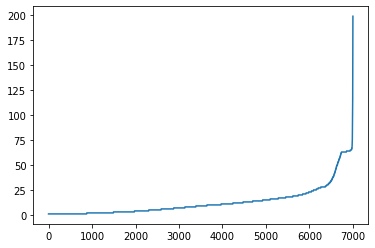

In [56]:
plt.plot(np.sort(length_list))

In [83]:
spk2utt_train_clean_truc = {}
spk2utt_val_truc = {}
new_count = 0
for count, i in enumerate(length_list):
    if i>=2:
        spk2utt_train_clean_truc[new_count] = spk2utt_train_clean[count]
        if (count in spk2utt_val):
            spk2utt_val_truc[new_count] = spk2utt_val[count]
        new_count += 1
    
    else:
        if (count in spk2utt_val):
            print(count)
            pass

In [76]:
len(spk2utt_train_clean_truc)

6123

In [84]:
len(spk2utt_val_truc)

200

In [85]:
with open(spk2utt_train_dict+'_clean_truc', 'wb') as handle:
    pickle.dump(spk2utt_train_clean_truc, handle)
with open(spk2utt_val_dict+'_truc', 'wb') as handle:
    pickle.dump(spk2utt_val_truc, handle)

## Make val

In [87]:
spk2utt_val_len_dict = {}

In [88]:
err = []
with open(spk2utt_val_dict+'_truc', 'rb') as handle:
    spk2utt_val = pickle.load(handle)

for i in spk2utt_val:
    for utt in spk2utt_val[i]:
        try:
            spk2utt_val_len_dict[utt] = librosa.core.load(utt, sr=16000)[0].shape[0]
        except Exception:
            err.append(utt)
            continue
    print(i)

7
72
75
210
235
300
302
317
319
376
396
405
408
436
540
622
635
661
689
694
695
714
721
845
905
915
928
948
961
969
996
998
1042
1047
1056
1060
1070
1095
1123
1135
1145
1167
1182
1186
1200
1202
1229
1274
1340
1344
1356
1419
1486
1502
1516
1527
1541
1574
1713
1718
1719
1730
1740
1766
1829
1847
1853
1864
1891
1900
1908
1912
2009
2023
2117
2127
2143
2173
2180
2186
2218
2220
2228
2251
2302
2334
2341
2378
2381
2404
2411
2435
2450
2525
2545
2596
2600
2624
2642
2671
2677
2713
2744
2783
2791
2856
2908
2940
2966
3001
3045
3089
3179
3254
3286
3289
3302
3313
3435
3473
3507
3562
3576
3589
3613
3626
3644
3665
3666
3690
3713
3742
3848
3901
3902
3933
4005
4043
4074
4081
4196
4197
4224
4238
4353
4392
4411
4457
4479
4526
4533
4543
4544
4583
4604
4646
4650
4665
4667
4668
4701
4710
4755
4891
4948
4963
4973
5045
5100
5116
5119
5139
5140
5195
5293
5299
5407
5424
5457
5467
5470
5500
5632
5635
5664
5804
5817
5827
5842
5880
5888
5927
5953
5971
6041
6073
6097
6102
6104
6121


In [89]:
err

[]

In [90]:
with open(spk2utt_val_len, 'wb') as handle:
    pickle.dump(spk2utt_val_len_dict, handle)

# Make train data

In [7]:
from preprocessing.Utils.preprocessing_logmel import logmel_IterableDataset

In [8]:
data_dir_dict = {}

data_dir_dict['spk2utt_train_dict'] = os.path.join(INFO_DIR, 'spk2utt_train_dict_clean_truc')
data_dir_dict['music_dict'] = os.path.join(AUG_INFO_DIR, 'music_dict')
data_dir_dict['noise_dict'] = os.path.join(AUG_INFO_DIR, 'noise_dict')
data_dir_dict['babble_dict'] = os.path.join(AUG_INFO_DIR, 'babble_dict')
data_dir_dict['rir_dict'] = os.path.join(AUG_INFO_DIR, 'rir_dict')

In [9]:
data_len_dict = {}

data_len_dict['spk2utt_train_len'] = os.path.join(INFO_DIR, 'spk2utt_train_len')
data_len_dict['music_len'] = os.path.join(AUG_INFO_DIR, 'music_len')
data_len_dict['noise_len'] = os.path.join(AUG_INFO_DIR, 'noise_len')
data_len_dict['babble_len'] = os.path.join(AUG_INFO_DIR, 'babble_len')

## Multi episode process

In [10]:
PROCESS = 1500
RUNNING_P = 10
# RUNNING_P = 1

# MFCC_O = os.path.join(OPT_INDEX, 'MFCC')
LOGMELFB_O = os.path.join(OPT_INDEX, 'FB')
# RAWWAV_O = os.path.join(OPT_INDEX, 'RW')
EER_LOG = os.path.join(OPT_INDEX, 'EER_LOG')
G_LOG = os.path.join(OPT_INDEX, 'G_LOG')

In [11]:
# if not os.path.exists(MFCC_O):
#     os.mkdir(MFCC_O)
# else:
#     shutil.rmtree(MFCC_O)
#     os.mkdir(MFCC_O)
    
if not os.path.exists(LOGMELFB_O):
    os.mkdir(LOGMELFB_O)
else:
    shutil.rmtree(LOGMELFB_O)
    os.mkdir(LOGMELFB_O)
    
# if not os.path.exists(RAWWAV_O):
#     os.mkdir(RAWWAV_O)
# else:
#     shutil.rmtree(RAWWAV_O)
#     os.mkdir(RAWWAV_O)

with open(EER_LOG, 'w') as f:
    pass

with open(G_LOG, 'w') as f:
    pass

In [12]:
config = {}

config['sr'] = 16000
config['repeats'] = 1
config['batch_size'] = 1

In [13]:
def iter_data_preload(dataset, i):
    dataset.get_random_list()
    try:
        start_time = time.time()
        for count, (rw, fb, mfcc, label) in enumerate(dataset):                
            file_name = str(i)+str('_')+str(count)
#             with open(os.path.join(RAWWAV_O, file_name), 'wb') as handle:
#                 pickle.dump((rw.astype(np.float16), label.astype(np.int16)), handle)
                
            with open(os.path.join(LOGMELFB_O, file_name), 'wb') as handle:
                pickle.dump((fb.astype(np.float16), label.astype(np.int16)), handle)
                
#             with open(os.path.join(MFCC_O, file_name), 'wb') as handle:
#                 pickle.dump((mfcc.astype(np.float16), label.astype(np.int16)), handle)
            
            with open(G_LOG, 'a') as f:
                f.write(str(time.time()-start_time)+'\n')
            start_time = time.time()
            
    except Exception:
        with open(EER_LOG, 'a') as f:
            traceback.print_exc(file=f)         
        raise Exception

dataset = logmel_IterableDataset(config, data_dir_dict, data_len_dict)
dataset.noise_data_preload()

p_list = []
for i in range(PROCESS // RUNNING_P):
    p_list.append([j for j in range(i*RUNNING_P, i*RUNNING_P+RUNNING_P)])
if (PROCESS % RUNNING_P) != 0:
    p_list.append([j for j in range((i+1)*RUNNING_P, PROCESS)])

print('episode', len(p_list))
print('last episode', p_list[-1])

start_time = time.time()
for ps in p_list:
    print(ps[0])
    processes = [Process(target = iter_data_preload, args = (dataset, i)) for i in ps]
    [p.start() for p in processes]
    joined = [p.join() for p in processes]

preloading music_dict
100
200
300
400
500
600
preloading noise_dict
100
200
300
400
500
600
700
800
900
preloading babble_dict
100
200
300
400
episode 150
last episode [1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499]
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490


# Make train index

In [19]:
# train_mfcc_dir = os.path.join(INFO_DIR, 'train_mfcc.csv')
train_fb_dir = os.path.join(INFO_DIR, 'train_fb.csv')
# train_rw_dir = os.path.join(INFO_DIR, 'train_raw.csv')

In [20]:
# mfcc_len = glob.glob(MFCC_O+'/*')
fb_len = glob.glob(LOGMELFB_O+'/*')
# raw_len = glob.glob(RAWWAV_O+'/*')

In [21]:
# print('mfcc', len(mfcc_len))
print('fb', len(fb_len))
# print('raw', len(raw_len))

fb 9184500


In [22]:
# count = 0
# with open(train_mfcc_dir, 'w') as f:
#     for path in mfcc_len:
#         assert os.path.isfile(path)
#         f.write(path+'\n')
#         count += 1
# print('mfcc', count)

count = 0
with open(train_fb_dir, 'w') as f:
    for path in fb_len:
        assert os.path.isfile(path)
        f.write(path+'\n')
        count += 1
print('fb', count)

# count = 0
# with open(train_rw_dir, 'w') as f:
#     for path in raw_len:
#         assert os.path.isfile(path)
#         f.write(path+'\n')
#         count += 1
# print('raw', count)

fb 9184500


In [18]:
6123*1500

9184500

# Make validation data (Need only once)

In [ ]:
OPT_INDEX = '/Lun0/zhiyong/dataset'
data_dir_dict = {}

# val
data_dir_dict['spk2utt_train_dict'] = os.path.join(OPT_INDEX, 'spk2utt_val_dict')
data_dir_dict['music_dict'] = os.path.join(OPT_INDEX, 'music_dict')
data_dir_dict['noise_dict'] = os.path.join(OPT_INDEX, 'noise_dict')
data_dir_dict['babble_dict'] = os.path.join(OPT_INDEX, 'babble_dict')
data_dir_dict['rir_dict'] = os.path.join(OPT_INDEX, 'rir_dict')

In [ ]:
data_len_dict = {}

data_len_dict['spk2utt_train_len'] = os.path.join(OPT_INDEX, 'spk2utt_val_len')
data_len_dict['music_len'] = os.path.join(OPT_INDEX, 'music_len')
data_len_dict['noise_len'] = os.path.join(OPT_INDEX, 'noise_len')
data_len_dict['babble_len'] = os.path.join(OPT_INDEX, 'babble_len')

In [ ]:
config = {}

config['sr'] = 16000
config['repeats'] = 5
config['batch_size'] = 1
config['extended_prefectch'] = 1.0
config['out_dir'] = '/Lun0/zhiyong/dataset/val_data_1000/'

def iter_data_preload(dataset, i):
    dataset.get_random_list()
    start_time = time.time()
    for count, (data, label) in enumerate(dataset):
        with open(config['out_dir']+str(i)+'_'+str(count), 'wb') as handle:
            pickle.dump((data.astype(np.float16), label.astype(np.int16)), handle)
        print(time.time()-start_time)
        start_time = time.time()

dataset = VoxIterableDataset(data_dir_dict, data_len_dict, config)
dataset.noise_data_preload()

processes = [Process(target = iter_data_preload, args = (dataset, i)) for i in range(1)]
start_time = time.time()
[p.start() for p in processes]
joined = [p.join() for p in processes]
print(time.time()-start_time)

# Make validation index (Need only once)

In [ ]:
OPT_INDEX = '/Lun0/zhiyong/dataset'
train_data_dir = os.path.join(OPT_INDEX, 'val_data_1000')
expected_len = 1000
workers = 1
single_worker_len = int(expected_len / workers)
output = os.path.join(OPT_INDEX, 'val_data_1000_csv.csv')

In [ ]:
assert expected_len == len(glob.glob(train_data_dir+'/*'))

In [ ]:
count = 0
with open(output, 'w') as f:
    for i in range(workers):
        for j in range(single_worker_len):
            path = os.path.join(train_data_dir, str(i)+'_'+str(j))
            assert os.path.isfile(path)
            f.write(path+'\n')
            count += 1

In [ ]:
count